## BUSINESS DENSITY ANALYSIS IN PARIS FRANCE

# Problem Statement

Even when Entrepreneurs posses the capital required in setting up a business. Choosing the right location that can attract potential customers for the  business is a major decision to make. Even when a city is chosen, it requires further business density analysis or neighbourhood analysis in order to choose a suitable neigbourhood for the business.

# Background

This project will be implemented in Paris - France, owing to the fact that its the Capital city of France and a historic touristic city. 

# Target Audience

This project could be use by the following individuals:
    1. Business persons with interest in setting up small businesses in Paris
    2. Customers looking for where to obtain particular services in Paris
    3. Tourists interested in visiting and spending quality time in Paris for the first time
    4. Paris city administration interested in channelling balance business set ups in particular neighbourhoods in the city
    5. Government interested in balance developments in the city of Paris.

# Project Objectives:

- Build a dataframe of neighborhoods in Paris - France by web scraping the data from Wikipedia page
- Get the geographical coordinates of the neighborhoods using the geocoder function
- Obtain the venue data for the neighborhoods from Foursquare API
- Explore and cluster the neighborhoods
- Select the best cluster to open a new business

# Import Libraries necessary for the project

In [1]:
import urllib.request # open and read URLs
import json # handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import requests # handle requests
import pandas as pd # process data as dataframes with Pandas
import numpy as np # handle data in a vectorized manner with NumPy
# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't installed the GeoPy geocoding library yet
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't installed the Folium library yet
import folium # map rendering library
# Matplolib plotting library and associated modules
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans # for K-Means clustering with Scikit-Learn
print("Libraries imported!")

Libraries imported!


# Connect to a csv file containing open data on Paris Neighbourhoods(Arrondissements) and transform to a Dataframe

In [3]:
dfs = pd.read_csv('arrondissements.csv', sep=';')
df=dfs[['C_AR', 'L_AR', 'L_AROFF', 'Geometry X Y']]
df[['Latitude','Longitude']]=df['Geometry X Y'].str.split(",",expand=True,)
df[['Latitude','Longitude']] = df[['Latitude','Longitude']].astype(float)
df1 = df.drop(df[['L_AR', 'Geometry X Y']], axis=1)
df1.columns = ['Arrondissement', 'Neighborhood', 'Latitude', 'Longitude']
paris_data = df1.sort_values(["Arrondissement"]).reset_index(drop=True)
paris_data.loc[paris_data.Neighborhood == "Élysée", ["Neighborhood"]] = "Elysée"
paris_data

,Arrondissement,Neighborhood,Latitude,Longitude
0,1,Louvre,48.862563,2.336443
1,2,Bourse,48.868279,2.342803
2,3,Temple,48.862872,2.360001
3,4,Hôtel-de-Ville,48.854341,2.357630
4,5,Panthéon,48.844443,2.350715
5,6,Luxembourg,48.849130,2.332898
6,7,Palais-Bourbon,48.856174,2.312188
7,8,Elysée,48.872721,2.312554
8,9,Opéra,48.877164,2.337458
9,10,Entrepôt,48.876130,2.360728


# Use GeoPy library to get the geographical coordinates of Paris

In [4]:
address = "Paris, FR"
geolocator = Nominatim(user_agent="my-application")
location_par = geolocator.geocode(address)
latitude_par = location_par.latitude
longitude_par = location_par.longitude
print("The geograpical coordinates of Paris are {}, {}.".format(latitude_par, longitude_par))

The geograpical coordinates of Paris are 48.8566101, 2.3514992.


# Visualise Paris on a Map

In [5]:
map_paris = folium.Map(location=[latitude_par, longitude_par], zoom_start=12)
# add markers to the map
for lat, lng, arrondissement, neighborhood in zip(paris_data['Latitude'], paris_data['Longitude'], paris_data['Arrondissement'], paris_data['Neighborhood']):
    label = "{}, {}".format(arrondissement,neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = "blue",
        fill = True,
        fill_color = "#3186cc",
        fill_opacity = 0.7,
        parse_html = False).add_to(map_paris) 
map_paris.save('Paris.png')
map_paris

# Use Foursquare API to explore Neighbourhoods and segnment the data

# Foursquare credentials

In [6]:
CLIENT_ID = 'IZJNDNMGN2UG0QC4VTSCO0X3FIJCUWLEOMDME03AZXXKSFK1' # your Foursquare ID
CLIENT_SECRET = '2VRK4XTUNZGWEC5FU3ITX45S3KRWYECKYHE10VK0EJLMJHGJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IZJNDNMGN2UG0QC4VTSCO0X3FIJCUWLEOMDME03AZXXKSFK1
CLIENT_SECRET:2VRK4XTUNZGWEC5FU3ITX45S3KRWYECKYHE10VK0EJLMJHGJ


# Function to get venues

In [7]:
def getNearbyVenues_paris(arrondissements, names, latitudes, longitudes, radius=750, limit=100):
    
    venues_list = []
    for arrondissement, name, lat, lng in zip(arrondissements, names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            arrondissement,
            name, 
            lat, 
            lng, 
            v["venue"]["name"], 
            v["venue"]["location"]["lat"], 
            v["venue"]["location"]["lng"],  
            v["venue"]["categories"][0]["name"]) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ["Arrondissement",
                  "Neighborhood", 
                  "Neighborhood Latitude", 
                  "Neighborhood Longitude", 
                  "Venue", 
                  "Venue Latitude", 
                  "Venue Longitude", 
                  "Venue Category"]   
    return(nearby_venues)

In [8]:
paris_venues = getNearbyVenues_paris(arrondissements=paris_data["Arrondissement"],
                               names = paris_data["Neighborhood"],
                               latitudes = paris_data["Latitude"],
                               longitudes = paris_data["Longitude"]
                               )

Louvre
Bourse
Temple
Hôtel-de-Ville
Panthéon
Luxembourg
Palais-Bourbon
Elysée
Opéra
Entrepôt
Popincourt
Reuilly
Gobelins
Observatoire
Vaugirard
Passy
Batignolles-Monceau
Buttes-Montmartre
Buttes-Chaumont
Ménilmontant


In [9]:
print(paris_venues.shape)

(1815, 8)


In [10]:
print("There are {} unique categories.".format(len(paris_venues["Venue Category"].unique())))

There are 222 unique categories.


In [11]:
paris_venues.head()

,Arrondissement,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,Louvre,48.862563,2.336443,Musée du Louvre,48.860847,2.336440,Art Museum
1,1,Louvre,48.862563,2.336443,Comédie-Française,48.863088,2.336612,Theater
2,1,Louvre,48.862563,2.336443,Palais Royal,48.863758,2.337121,Historic Site
3,1,Louvre,48.862563,2.336443,Place du Palais Royal,48.862523,2.336688,Plaza
4,1,Louvre,48.862563,2.336443,La Clef Louvre Paris,48.863977,2.336140,Hotel


# Use Onehot encoding to explore Neighbourhoods

In [12]:
paris_onehot = pd.get_dummies(paris_venues[["Venue Category"]], prefix="", prefix_sep="")
# add arrondissement and neighborhood column back to dataframe
paris_onehot["Arrondissement"] = paris_venues["Arrondissement"] 
paris_onehot["Neighborhood"] = paris_venues["Neighborhood"] 
# move arrondissement and neighborhood columns to the first columns
fixed_columns = [paris_onehot.columns[-2], paris_onehot.columns[-1]] + list(paris_onehot.columns[:-2])
paris_onehot = paris_onehot[fixed_columns]
paris_onehot.head()

,Arrondissement,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,1,Louvre,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,Louvre,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,Louvre,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,Louvre,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,Louvre,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Group by neighborhood and by the mean frequency for each category

In [13]:
paris_grouped = paris_onehot.groupby("Neighborhood").mean().reset_index()
paris_grouped.head()

,Neighborhood,Arrondissement,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Batignolles-Monceau,17,0.0,0.00,0.010417,0.0,0.00,0.00,0.00,0.00,...,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.010417,0.0
1,Bourse,2,0.0,0.00,0.010000,0.0,0.00,0.00,0.00,0.00,...,0.0,0.00,0.0,0.0,0.00,0.05,0.01,0.01,0.000000,0.0
2,Buttes-Chaumont,19,0.0,0.00,0.010000,0.0,0.00,0.00,0.00,0.00,...,0.0,0.00,0.0,0.0,0.01,0.00,0.00,0.00,0.000000,0.0
3,Buttes-Montmartre,18,0.0,0.01,0.000000,0.0,0.01,0.01,0.02,0.00,...,0.0,0.02,0.0,0.0,0.02,0.02,0.00,0.00,0.000000,0.0
4,Elysée,8,0.0,0.00,0.000000,0.0,0.00,0.00,0.04,0.01,...,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.000000,0.0


# Top 5 most common categories of venues for each neighborhood 

In [14]:
num_top_venues = 5
for hood in paris_grouped["Neighborhood"]:
    print("----"+hood+"----")
    temp = paris_grouped[paris_grouped["Neighborhood"]==hood].T.reset_index()
    temp.columns = ["venue","freq"]
    temp = temp.iloc[2:]
    temp["freq"] = temp["freq"].astype(float)
    temp = temp.round({"freq": 2})
    print(temp.sort_values("freq", ascending=False).reset_index(drop=True).head(num_top_venues))
    print("\n")

----Batignolles-Monceau----
                 venue  freq
0   Italian Restaurant  0.14
1    French Restaurant  0.14
2                Hotel  0.12
3  Japanese Restaurant  0.05
4               Bakery  0.05


----Bourse----
                venue  freq
0   French Restaurant  0.15
1              Bistro  0.06
2        Cocktail Bar  0.05
3            Wine Bar  0.05
4  Italian Restaurant  0.04


----Buttes-Chaumont----
               venue  freq
0                Bar  0.13
1  French Restaurant  0.08
2              Hotel  0.05
3        Pizza Place  0.05
4        Supermarket  0.04


----Buttes-Montmartre----
                venue  freq
0   French Restaurant  0.20
1                 Bar  0.15
2         Pizza Place  0.06
3  Italian Restaurant  0.05
4              Bistro  0.05


----Elysée----
                venue  freq
0   French Restaurant  0.17
1               Hotel  0.17
2         Art Gallery  0.04
3              Bakery  0.04
4  Italian Restaurant  0.04


----Entrepôt----
                venue  fr

- Considering that Paris is a touristic city, Hotels, restaurants, Coffee shops, Bakery and Bars dominates most neighbourhoods.
- In Reuilly neigbourhood, despite enormous touristic potentials, restaurants and hotels seem to absent. This could be a great investment opportunity for an investor
- Banks also seem not to be very common in most communities this also represent a great investment opportunities.

# Define a function to sort the venues in descending order

In [15]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

# The top 10 venues for each neighborhood

In [16]:
num_top_venues = 10
indicators = ["st", "nd", "rd"]
# create columns according to number of top venues
columns = ["Arrondissement", "Neighborhood"]
for ind in np.arange(num_top_venues):
    try:
        columns.append("{}{} Most Common Venue".format(ind+1, indicators[ind]))
    except:
        columns.append("{}th Most Common Venue".format(ind+1))
# create a new dataframe
paris_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
paris_neighborhoods_venues_sorted[[ "Arrondissement","Neighborhood"]] = paris_grouped[["Arrondissement","Neighborhood"]]
for ind in np.arange(paris_grouped.shape[0]):
    paris_neighborhoods_venues_sorted.iloc[ind, 2:] = return_most_common_venues(paris_grouped.iloc[ind, 1:], num_top_venues)
paris_neighborhoods_venues_sorted

,Arrondissement,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,17,Batignolles-Monceau,French Restaurant,Italian Restaurant,Hotel,Japanese Restaurant,Bakery,Restaurant,Café,Bistro,Plaza,Bar
1,2,Bourse,French Restaurant,Bistro,Wine Bar,Cocktail Bar,Italian Restaurant,Boutique,Japanese Restaurant,Bakery,Creperie,Hotel
2,19,Buttes-Chaumont,Bar,French Restaurant,Pizza Place,Hotel,Supermarket,Smoke Shop,Café,Bistro,Restaurant,Seafood Restaurant
3,18,Buttes-Montmartre,French Restaurant,Bar,Pizza Place,Bistro,Italian Restaurant,Coffee Shop,Café,Art Gallery,Middle Eastern Restaurant,Convenience Store
4,8,Elysée,French Restaurant,Hotel,Art Gallery,Italian Restaurant,Bakery,Theater,Clothing Store,Japanese Restaurant,Thai Restaurant,Boutique
5,10,Entrepôt,French Restaurant,Coffee Shop,Bistro,Pizza Place,Japanese Restaurant,Italian Restaurant,Bakery,Breakfast Spot,Indian Restaurant,Cocktail Bar
6,13,Gobelins,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,French Restaurant,Chinese Restaurant,Bakery,Hotel,Cantonese Restaurant,Japanese Restaurant,Cambodian Restaurant
7,4,Hôtel-de-Ville,French Restaurant,Ice Cream Shop,Plaza,Wine Bar,Tapas Restaurant,Pastry Shop,Bakery,Cocktail Bar,Clothing Store,Gastropub
8,1,Louvre,French Restaurant,Plaza,Hotel,Café,Japanese Restaurant,Exhibit,Historic Site,Udon Restaurant,Art Museum,Cosmetics Shop
9,6,Luxembourg,French Restaurant,Hotel,Italian Restaurant,Wine Bar,Chocolate Shop,Bistro,Seafood Restaurant,Tea Room,Plaza,Pastry Shop


# Cluster the venues and visualize them on a map

Create the metric (same squared distances) to identify the best k

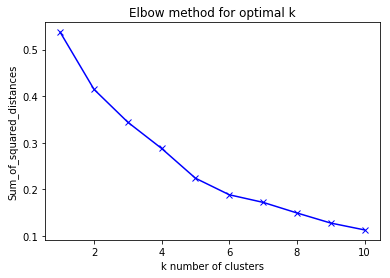

In [17]:
columns = ["Neighborhood", "Arrondissement"]
paris_grouped_clustering = paris_grouped.drop(columns, axis = 1)
Sum_of_squared_distances = []
ks = range(1,11)
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(paris_grouped_clustering)
    Sum_of_squared_distances.append(kmeans.inertia_)

# Plot of sum of squared distances
plt.plot(ks, Sum_of_squared_distances, "bx-")
plt.xlabel("k number of clusters")
plt.ylabel("Sum_of_squared_distances")
plt.title("Elbow method for optimal k")
plt.show()

According to the figure above, the correct value for k could be 4 or 5. Here, we choose to cluster the data points using k=5.

# Cluster the venues of Paris into 5 clusters

In [18]:
kclusters = 5
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 1, 1, 1, 3, 1, 4, 1, 1, 1], dtype=int32)

In [19]:
paris_merged = paris_data
# add clustering labels
paris_merged["Cluster Labels"] = kmeans.labels_
paris_merged = pd.merge(paris_merged, paris_neighborhoods_venues_sorted,  how = "left", left_on = ["Arrondissement","Neighborhood"], right_on = ["Arrondissement","Neighborhood"])
paris_merged

,Arrondissement,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Louvre,48.862563,2.336443,3,French Restaurant,Plaza,Hotel,Café,Japanese Restaurant,Exhibit,Historic Site,Udon Restaurant,Art Museum,Cosmetics Shop
1,2,Bourse,48.868279,2.342803,1,French Restaurant,Bistro,Wine Bar,Cocktail Bar,Italian Restaurant,Boutique,Japanese Restaurant,Bakery,Creperie,Hotel
2,3,Temple,48.862872,2.360001,1,French Restaurant,Art Gallery,Coffee Shop,Gourmet Shop,Wine Bar,Italian Restaurant,Chinese Restaurant,Moroccan Restaurant,Sandwich Place,Cocktail Bar
3,4,Hôtel-de-Ville,48.854341,2.357630,1,French Restaurant,Ice Cream Shop,Plaza,Wine Bar,Tapas Restaurant,Pastry Shop,Bakery,Cocktail Bar,Clothing Store,Gastropub
4,5,Panthéon,48.844443,2.350715,3,French Restaurant,Bar,Wine Bar,Café,Hotel,Bakery,Plaza,Coffee Shop,Greek Restaurant,Museum
5,6,Luxembourg,48.849130,2.332898,1,French Restaurant,Hotel,Italian Restaurant,Wine Bar,Chocolate Shop,Bistro,Seafood Restaurant,Tea Room,Plaza,Pastry Shop
6,7,Palais-Bourbon,48.856174,2.312188,4,French Restaurant,Hotel,Plaza,Italian Restaurant,Café,Cocktail Bar,History Museum,Historic Site,Ice Cream Shop,Bar
7,8,Elysée,48.872721,2.312554,1,French Restaurant,Hotel,Art Gallery,Italian Restaurant,Bakery,Theater,Clothing Store,Japanese Restaurant,Thai Restaurant,Boutique
8,9,Opéra,48.877164,2.337458,1,French Restaurant,Hotel,Cocktail Bar,Italian Restaurant,Bistro,Bar,Bakery,Wine Bar,Lounge,Pizza Place
9,10,Entrepôt,48.876130,2.360728,1,French Restaurant,Coffee Shop,Bistro,Pizza Place,Japanese Restaurant,Italian Restaurant,Bakery,Breakfast Spot,Indian Restaurant,Cocktail Bar


# Represent Clusters on a map

In [20]:
map_clusters = folium.Map(location=[latitude_par, longitude_par], zoom_start=12)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged["Latitude"], paris_merged["Longitude"], paris_merged["Neighborhood"], paris_merged["Cluster Labels"]):
    label = folium.Popup(str(poi) + "Cluster" + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster-1],
        fill = True,
        fill_color = rainbow[cluster-1],
        fill_opacity = 0.7).add_to(map_clusters)       
map_clusters

# Cluster 1: Red

In [21]:
paris_merged.loc[paris_merged["Cluster Labels"] == 0, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Buttes-Montmartre,French Restaurant,Bar,Pizza Place,Bistro,Italian Restaurant,Coffee Shop,Café,Art Gallery,Middle Eastern Restaurant,Convenience Store


Most common venues in Cluster 1 are restauration services consisting of restaurants, Bars and Café shops. This represents 80% of the venues. 
Opportunities exists here for the establishment of other businesses like Hotels, banks, book stores, education services, Insurance, Shopping Centers, etc.

# Cluster 2: Purple

In [23]:
paris_merged.loc[paris_merged["Cluster Labels"] == 1, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bourse,French Restaurant,Bistro,Wine Bar,Cocktail Bar,Italian Restaurant,Boutique,Japanese Restaurant,Bakery,Creperie,Hotel
2,Temple,French Restaurant,Art Gallery,Coffee Shop,Gourmet Shop,Wine Bar,Italian Restaurant,Chinese Restaurant,Moroccan Restaurant,Sandwich Place,Cocktail Bar
3,Hôtel-de-Ville,French Restaurant,Ice Cream Shop,Plaza,Wine Bar,Tapas Restaurant,Pastry Shop,Bakery,Cocktail Bar,Clothing Store,Gastropub
5,Luxembourg,French Restaurant,Hotel,Italian Restaurant,Wine Bar,Chocolate Shop,Bistro,Seafood Restaurant,Tea Room,Plaza,Pastry Shop
7,Elysée,French Restaurant,Hotel,Art Gallery,Italian Restaurant,Bakery,Theater,Clothing Store,Japanese Restaurant,Thai Restaurant,Boutique
8,Opéra,French Restaurant,Hotel,Cocktail Bar,Italian Restaurant,Bistro,Bar,Bakery,Wine Bar,Lounge,Pizza Place
9,Entrepôt,French Restaurant,Coffee Shop,Bistro,Pizza Place,Japanese Restaurant,Italian Restaurant,Bakery,Breakfast Spot,Indian Restaurant,Cocktail Bar
10,Popincourt,Bar,French Restaurant,Cocktail Bar,Bistro,Pizza Place,Italian Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Beer Bar,Wine Bar
14,Vaugirard,French Restaurant,Hotel,Italian Restaurant,Coffee Shop,Bistro,Persian Restaurant,Lebanese Restaurant,Park,Restaurant,Japanese Restaurant
16,Batignolles-Monceau,French Restaurant,Italian Restaurant,Hotel,Japanese Restaurant,Bakery,Restaurant,Café,Bistro,Plaza,Bar


Cluster 2 has eleven neighbourhood consisting of mainly restauration services and hotels. This could also be a great location for the establishment of shpping centers, bakery and a banks

# Cluster 3: Blue 

In [24]:
paris_merged.loc[paris_merged["Cluster Labels"] == 2, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Passy,Plaza,Lake,Pool,French Restaurant,Garden,Diner,Skate Park,Bus Station,Bus Stop,Cafeteria


Cluster 3 also has one neighbourhood consisting of mainly restauration services and touristic sites. Business like banks or payment counters and hotels could also be established here

# Cluster 4: Green

In [25]:
paris_merged.loc[paris_merged["Cluster Labels"] == 3, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Louvre,French Restaurant,Plaza,Hotel,Café,Japanese Restaurant,Exhibit,Historic Site,Udon Restaurant,Art Museum,Cosmetics Shop
4,Panthéon,French Restaurant,Bar,Wine Bar,Café,Hotel,Bakery,Plaza,Coffee Shop,Greek Restaurant,Museum
11,Reuilly,Lake,Zoo,Diner,Bus Stop,Exhibit,French Restaurant,Monument / Landmark,Japanese Restaurant,Hot Dog Joint,Fast Food Restaurant
12,Gobelins,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,French Restaurant,Chinese Restaurant,Bakery,Hotel,Cantonese Restaurant,Japanese Restaurant,Cambodian Restaurant
13,Observatoire,French Restaurant,Hotel,Italian Restaurant,Bistro,Café,Bar,Vietnamese Restaurant,Plaza,Bakery,Pizza Place
19,Ménilmontant,French Restaurant,Bar,Bakery,Plaza,Bistro,Italian Restaurant,Café,Park,Bookstore,Supermarket


Cluster 4 has six Neighborhoods consisting of mainly restauration services, touristic sites and few hotels. Hotels could be a great investment in this cluster. other posiible investments are shopping centers, retails shops, banks, etc.

# Cluster 5: Orange (west of Paris)

In [26]:
paris_merged.loc[paris_merged["Cluster Labels"] == 4, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Palais-Bourbon,French Restaurant,Hotel,Plaza,Italian Restaurant,Café,Cocktail Bar,History Museum,Historic Site,Ice Cream Shop,Bar


Cluster 5 has one Neighborhood mainly consisting of restauration, Hotels and touristic business venues. Additional restaurants, banks and retail shops could be established here.

- Considering that Paris is a touristic city, Hotels, restaurants, Coffee shops, Bakery and Bars dominates most neighbourhoods.
- In Reuilly neigbourhood, despite enormous touristic potentials, restaurants and hotels seem to absent. This could be a great investment opportunity for an investor
- Banks also seem not to be very common in most communities this also represent a great investment opportunities.

# Conclusion

Using Business density analysis, lots of opportunities exists to established competitive businesses in various neighborhoods of the city of Paris. This analysis can also be conducted in other cities in the World with adequate venues data in Foursquare. The results of this analysis when combined with other factors will enable improved business locations for sustainability.